## Import

In [116]:
import pandas as pd 
from datetime import datetime  
import numpy as np 
import os 
import sys
import torch

# Personnal Import 
from utilities_DL import get_loss,choose_optimizer,load_model,load_all,display_info_on_dataset,find_nearest_date
from DL_class import Trainer,PI_object,MultiModelTrainer
from PI import plot_bands_CQR
from config import get_config,get_parameters
from plotting import plot_k_fold_split
# ...

# Paths
folder_path = 'data/'

## Load Raw Data and forbidden dates : 

In [126]:
#Init and load data: 
H,W,D = 6,1,1
L = H+W+D 
step_ahead = 1

window_pred = np.arange(2*96)

# Load subway in data:
file_name = 'preprocessed_subway_15_min.csv'
file_name = 'subway_IN_interpol_neg_15_min_2019_2020.csv'
# Load CRITER data : 
#file_name = 'preprocessed_CRITER_6min.csv'



## Get Parameters

In [127]:
# Choose Model :
model_name =  'CNN' #'STGCN'
single_station = False   # Quick Training if True

# Choose config 
config = get_config(model_name = model_name,other_params= {'seq_length':L})
#config = get_config(model_name = model_name,learn_graph_structure = True,other_params= {'seq_length':L})  # MTGNN
args = get_parameters(config)

# Modification : 
args.epochs = 100
args.optimizer = 'adamw'
args.train_prop= 0.6
args.calib_prop=None
args.valid_prop= 0.2  

args.type_calendar = 'tuple'
args.embedding_dim = 2

if model_name == 'STGCN':
    args.gso_type = 'sym_norm_lap'
    args.graph_conv_type = 'graph_conv'
    args.act_fun = 'glu'
    args.Ks = 2

# Validation Sliding Window and others : 
Dans le cas où args.validation = 'sliding_window', la fonction 'load_all' va retourner une liste de model, liste d'optimizer, et une liste de dataloader. 

Sinon, par défault on a args.validation = 'classic', et on fait une Hold-out validation

In [129]:
funicular = ['Les Minimes - Théâtres Romains','Vieux Lyon','Fourvière','St Just']
df[funicular]

Station,Les Minimes - Théâtres Romains,Vieux Lyon,Fourvière,St Just
2019-01-01 00:00:00,0.0,17.0,0.0,0.0
2019-01-01 00:15:00,0.0,19.0,0.0,0.0
2019-01-01 00:30:00,0.0,11.0,0.0,0.0
2019-01-01 00:45:00,0.0,0.0,0.0,0.0
2019-01-01 01:00:00,0.0,0.0,0.0,0.0
...,...,...,...,...
2019-12-31 23:00:00,3.0,140.0,20.0,18.0
2019-12-31 23:15:00,0.0,99.0,11.0,11.0
2019-12-31 23:30:00,3.0,116.0,25.0,5.0
2019-12-31 23:45:00,0.0,116.0,35.0,15.0


coverage period: 2019-01-01 00:00:00 - 2020-01-01 00:00:00


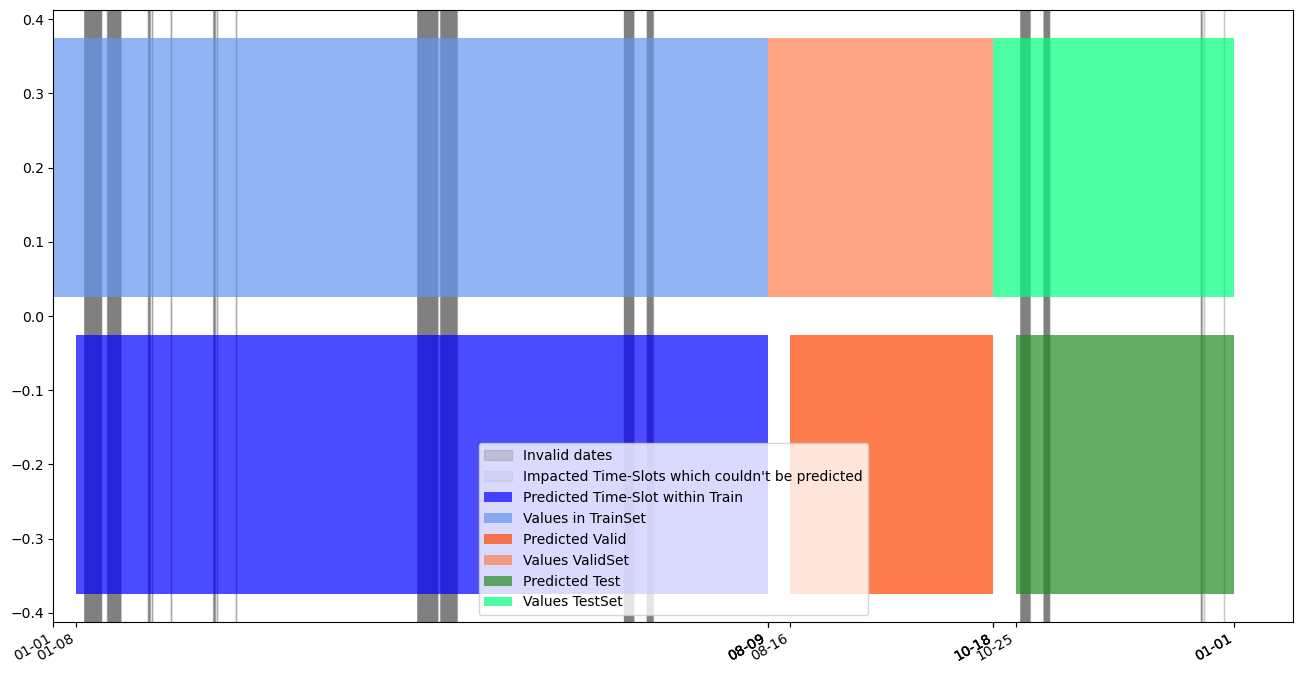

In [128]:
from utilities_DL import load_raw_data
from DL_class import DataSet
# Suite des codes à effectuer :

df,invalid_dates,time_step_per_hour = load_raw_data(folder_path,file_name,single_station = False)
dataset = DataSet(df,time_step_per_hour=time_step_per_hour, Weeks = W, Days = D, historical_len= H,step_ahead=step_ahead)

data_loader,time_slots_labels,dic_class2rpz,dic_rpz2class,nb_words_embedding = dataset.split_normalize_load_feature_vect(invalid_dates,args.train_prop, args.valid_prop,args.test_prop,args.calib_prop,args.batch_size,type_class= args.calendar_class,type_calendar = args.type_calendar)
plot_k_fold_split(dataset,invalid_dates)

# K-fold sliding window validation:

### Analyse de Subway_in  :
**Code Bokeh qui fonctionne pas bien. Il faudrait faire un checkbox en menu déroulant, pas tout afficher d'un coup, un bouton pour tout désactiver car 40 plot c'est long. Rajouter un 'hover', etc...**

In [69]:
from bokeh.plotting import figure, show, output_notebook, output_file, save
from bokeh.models import Legend, LegendItem,HoverTool
from bokeh.palettes import Turbo256
from bokeh.layouts import row
# Load df, remove forbidden values: 
df,invalid_dates,time_step_per_hour = load_raw_data(folder_path,file_name,single_station = False)
dataset = DataSet(df,time_step_per_hour=time_step_per_hour, Weeks = W, Days = D, historical_len= H,step_ahead=step_ahead)
dataset.get_shift_between_set()   # get shift indice and shift date from the first element / between each dataset 
dataset.get_feature_vect()  # Build 'df_shifted'.
dataset.remove_forbidden_prediction(invalid_dates) # Build 'df_verif' , which is df_shifted without sequences which contains invalid date

# Find atypical Value. Check if we need to modify them.
valid_df = dataset.df[~(dataset.df.index.isin(invalid_dates))]
limit = 1500
all_plot = False

p = figure(x_axis_type='datetime', height=600, width=1400, sizing_mode="scale_width")

# Stocker les renderers pour les ajouter à la légende
renderers = []

if all_plot:
    for i, column in enumerate(df.columns):
        x, y = df.index, df[column]
        color = Turbo256[int(256 / len(df.columns) * i)]  
        renderer = p.line(x, y, line_width=2, color=color, alpha=0.8, legend_label=column, muted_color=color, muted_alpha=0)
        renderer.visible = False
        renderers.append(renderer)

    legend = Legend(items=[LegendItem(label=col, renderers=[rend], index=i) for i, (col, rend) in enumerate(zip(df.columns, renderers))])

else:

    for i,column in enumerate(valid_df):
        color = Turbo256[int(256 / len(df.columns) * i)]  
        sub_df = valid_df[valid_df[column] > limit]
        if not sub_df.empty:
            x,y = sub_df.index,sub_df[column]
            renderer = p.scatter(x, y, color=color, alpha=0.8, legend_label=column, muted_color=color, muted_alpha=0)
            renderers.append(renderer)

    x,y = dataset.df.index,dataset.df.quantile(0.9,axis = 1)
    renderer = p.line(x, y, line_width=2, color='black', alpha=0.8, legend_label='all_stations', muted_color=color, muted_alpha=0)
    renderers.append(renderer)

    legend = Legend(items=[LegendItem(label=col, renderers=[rend], index=i) for i, (col, rend) in enumerate(zip(list(df.columns)+['all_stations'], renderers))])  


p.add_layout(legend, 'right')
p.legend.click_policy = "mute"
hover = HoverTool()
p.add_tools(hover)
output_notebook()
show(p) 

output_file("df_IN_outliers.html")
save(p)

coverage period: 2019-01-01 00:00:00 - 2020-01-01 00:00:00


Loading BokehJS ...

'c:\\Users\\romai\\Code\\prediction-validation\\df_IN_outliers.html'

In [74]:
p = figure(x_axis_type='datetime', height=600, width=1400, sizing_mode="scale_width")

column = 'Ampère Victor Hugo'
column = 'Bellecour'
x,y = dataset.df.index,dataset.df[column]

renderer = p.line(x, y, color='blue', alpha=0.8, legend_label=column, muted_color=color, muted_alpha=0)

output_notebook()
show(p) 

output_file(f"df_IN_{column}.html")
save(p)

Loading BokehJS ...

'c:\\Users\\romai\\Code\\prediction-validation\\df_IN_Bellecour.html'

- 10 Janvier 2019 (01_10_2019 - 15:30:00)   - 14 Janvier 2019 (01_14_2019 - 15:30:00 )
- 30 Janvier 2019 (01_30_2019 - 8:30:00)    - 30 Janvier 2019 (01_30_2019 - 10:30:00 ) 
- 19 Fevrier 2019 (02_19_2019 - 11:00:00)    - 19 Fevrier 2019 (02_19_2019 - 13:00:00 ) 
- 26 Juin 2019 ( 06_26_2019 - 11:00:00) - 28 Juin 2019 ( 06_28_2019 - 04:00:00)
- 27 octobre 2019 (10_27_2019 - 00:00:00) - 28 octobre 2019 (10_28_2019 - 16:00:00)
- 21 Decembre 2019 (12_21_2019 - 15:45:00) - 21 Decembre 2019 (12_21_2019 - 16:45:00)

pic sur station :
- ?? le 2 Mars 2019 - 21:45:00
- ?? le 24 Mars - ~23:45:00
- ?? le 25 Mars ~23:00:00
- ?? le 4 Avril ~23:00:00
- ?? le 29 Juillet 2019 - 14:00:00
- ?? le 25 Decembre 2019
- ?? le 27 decembre 2019

### On déduit les invalid_dates  pour subway IN: 

coverage period: 2019-01-01 00:00:00 - 2020-01-01 00:00:00


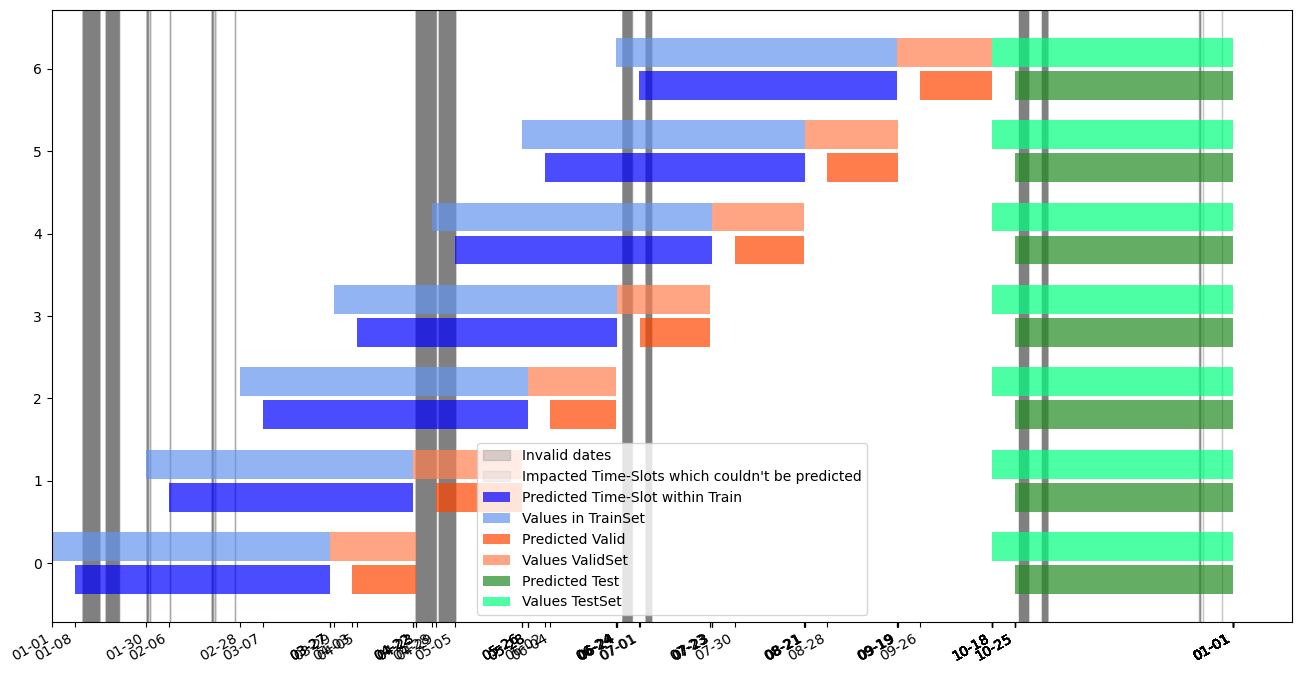

In [75]:
from utilities_DL import load_raw_data
from DL_class import DataSet
# Suite des codes à effectuer :

df,invalid_dates,time_step_per_hour = load_raw_data(folder_path,file_name,single_station = False)
dataset = DataSet(df,time_step_per_hour=time_step_per_hour, Weeks = W, Days = D, historical_len= H,step_ahead=step_ahead)

args.validation = 'sliding_window'
args.K_fold = 7
(Datasets,DataLoader_list,time_slots_labels_list,dic_class2rpz_list,dic_rpz2class_list,nb_words_embedding_list) =  dataset.split_K_fold(args.K_fold,invalid_dates,args.train_prop, args.valid_prop,args.test_prop,args.calib_prop,args.validation,args.batch_size,type_class= args.calendar_class,type_calendar = args.type_calendar,no_common_dates_between_set = args.no_common_dates_between_set)

plot_k_fold_split(Datasets,invalid_dates)

In [76]:
from utilities_DL import get_config_embed,get_parameters,load_model_and_optimizer

# Load Loss 
loss_function = get_loss(args.loss_function_type,args)
config_Tembed = get_config_embed(nb_words_embedding = nb_words_embedding_list[0],embedding_dim = args.embedding_dim,position = args.position)
args_embedding = get_parameters(config_Tembed,description = 'TimeEmbedding') if args.time_embedding else None

model_opt_list = [load_model_and_optimizer(args,args_embedding,dic_class2rpz_list[0]) for dataloader in DataLoader_list]
Model_list, Optimizer_list = [model_opt[0] for model_opt in model_opt_list], [model_opt[1] for model_opt in model_opt_list]

# Generate Test DataLoader, common to each of them:

In [88]:
trainset= DataLoader_list[0]['train']
train_data = [[x_b,y_b,t_b] for [x_b,y_b,t_b] in trainset]
X = torch.cat([x_b for x_b,_,_ in train_data])
Y = torch.cat([y_b for _,y_b,_ in train_data])
T = torch.cat([t_b for _,_,t_b in train_data])

In [112]:
len(df.columns)

43

In [110]:
print(X[:,-16,:])

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])


In [104]:
torch.where(torch.isnan(X))[0]

tensor([   0,    0,    0,  ..., 6628, 6628, 6628])

In [97]:
masks = []
for column in dataset.df.columns:
    serie = dataset.df[column]
    mask = serie.isna()
    if mask.sum() > 0:
        print(f"{column}: {mask.sum()} NaN values")
    masks.append(mask)



In [87]:
multimodeltrainer.Trainers[0].training_mode = 'train'
multimodeltrainer.Trainers[0].loop()
multimodeltrainer.Trainers[0].train_loss

[nan, nan]

In [77]:
# Load multi-model trainer : 
args.epochs = 1
multimodeltrainer = MultiModelTrainer(Model_list,DataLoader_list,args,Optimizer_list,loss_function,scheduler = None,args_embedding=args_embedding,ray= False, alpha = args.alpha)

# Train each model and get mean metrics :
(mean_picp,mean_mpiw,mean_last_train_loss,mean_last_valid_loss,min_mean_train_loss,min_mean_valid_loss) = multimodeltrainer.K_fold_validation()

print(f"mean_last_train_loss: {mean_last_train_loss}\nmean_last_valid_loss: {mean_last_valid_loss} \nPICP:{mean_picp}\nmean_mpiw: {mean_mpiw}")

K_fold 0
start training


epoch: 0 
 min\epoch : 0.04
Last Train Loss: nan,Last Valid Loss: nan,PICP: 0.0, MPIW: nan
K_fold 1
start training
epoch: 0 
 min\epoch : 0.05
Last Train Loss: nan,Last Valid Loss: nan,PICP: 0.0, MPIW: nan
K_fold 2
start training
epoch: 0 
 min\epoch : 0.04
Last Train Loss: nan,Last Valid Loss: nan,PICP: 0.0, MPIW: nan
K_fold 3
start training
epoch: 0 
 min\epoch : 0.04
Last Train Loss: 0.13219147271946113,Last Valid Loss: 0.03011933865503491,PICP: 0.9561921782201098, MPIW: 0.47994306683540344
K_fold 4
start training
epoch: 0 
 min\epoch : 0.04
Last Train Loss: 0.034657940345134516,Last Valid Loss: 0.018060186153082067,PICP: 0.9764245052651039, MPIW: 0.36905384063720703
K_fold 5
start training
epoch: 0 
 min\epoch : 0.04
Last Train Loss: 0.03198130278890758,Last Valid Loss: 0.033998627171084275,PICP: 0.9567198440882165, MPIW: 0.37321510910987854
K_fold 6
start training
epoch: 0 
 min\epoch : 0.04
Last Train Loss: 0.03581296510374876,Last Valid Loss: 0.04201671400510553,PICP: 0.96132247

## Suivi de la moyenne et variance des Validation_loss et training Loss le long des fold

In [7]:
from bokeh.plotting import figure, show, output_file,save,output_notebook
from bokeh.models import ColumnDataSource
import numpy as np

save_path = 'mean_and_deviation_K_fold'

mean_valid_loss = multimodeltrainer.Loss_valid.mean(axis = 0).numpy()
std_valid_loss = multimodeltrainer.Loss_valid.std(axis = 0).numpy()

mean_train_loss = multimodeltrainer.Loss_train.mean(axis = 0).numpy()
std_train_loss = multimodeltrainer.Loss_train.std(axis = 0).numpy()
xaxis = np.arange(len(mean_valid_loss))

source = ColumnDataSource(data=dict(x=xaxis, mean_valid_loss=mean_valid_loss, mean_train_loss=mean_train_loss,
                                     std_valid_low=mean_valid_loss-std_valid_loss, std_valid_high=mean_valid_loss+std_valid_loss,
                                     std_train_low=mean_train_loss-std_train_loss, std_train_high=mean_train_loss+std_train_loss))

# Création de la figure
p = figure(title="Mean and Variance of Training and Validation Loss ", x_axis_label='Epochs', y_axis_label='Loss')

# Ajout des lignes pour les moyennes
p.line('x', 'mean_valid_loss', source=source, legend_label="Mean Valid Loss", color="blue")
p.line('x', 'mean_train_loss', source=source, legend_label="Mean Train Loss", color="green")

# Ajout des bandes pour les écarts-types
p.varea(x='x', y1='std_valid_low', y2='std_valid_high', source=source,
                fill_alpha=0.3, fill_color='blue',legend_label = 'Range Valid Loss')
p.varea(x='x', y1='std_train_low', y2='std_train_high', source=source,
                fill_alpha=0.3, fill_color='green',legend_label = 'Range Train Loss')
p.legend.location = "top_right"

# Affichage du graphique
output_notebook()
show(p)
output_file(f"{save_path}.html")
save(p)

Loading BokehJS ...

'/Users/romainrochas/Desktop/Codes/Cleaned_Code/prediction_validation/mean_and_deviation_K_fold.html'

## Plot Latent Space Bokeh 

In [4]:
from plotting_bokeh import  generate_bokeh

In [5]:
for time_embedding_on in [True]:
    for bool_specific_lr in [False]:
        for calendar_class in [3,2,1,0]:
            for position in ['input']:
                for calib_prop in [None,0.5]:
                    # Update args 
                    args.time_embedding = time_embedding_on
                    args.calib_prop = calib_prop
                    args.calendar_class = calendar_class
                    args.specific_lr = bool_specific_lr
                    args.position = position
                    # ...
            
                    dataset,data_loader,dic_class2rpz,dic_rpz2class,args_embedding,loss_function,model,optimizer = load_all(folder_path,file_name,args,step_ahead,H,D,W,
                                embedding_dim=args.embedding_dim,position = args.position,single_station = single_station)
                    
                    # ======= Inversion de train et Valid =======
                    # data_loader['train'],data_loader['validate'] = data_loader['validate'],data_loader['train'] 
                    # ======= Inversion de train et Valid =======


                    # Metrics and save :
                    metrics = ['Epochs','train_loss','valid_loss','PICP','MPIW','PICP_cqr','MPIW_cqr']
                    results = pd.DataFrame(columns = metrics)
                    
                    # Save Directory
                    if args.model_name == 'STGCN':
                        save_dir =  f"save/{args.model_name}/{args.graph_conv_type}/{args.gso_type}/act_{args.act_fun}_Ks{args.Ks}_opt_{args.optimizer}/"
                        if args.time_embedding:
                            save_dir = save_dir + f"Specific_lr_{args.specific_lr}/CalendarClass{args.calendar_class}/position_{args_embedding.position}/"

                    if args.model_name == 'CNN':
                        save_dir = f"save/{args.model_name}/h_dims{'_'.join(list(map(str,args.H_dims)))}_out_dims{'_'.join(list(map(str,args.C_outs)))}_opt_{args.optimizer}/"  
                        if args.time_embedding:
                            save_dir = save_dir+ f"Specific_lr_{args.specific_lr}/CalendarClass{args.calendar_class}/position_{args_embedding.position}/"
                    if not os.path.exists(save_dir):
                        os.makedirs(save_dir)
                        
                    trial_save_init = f"reverse_train_valid_{'TE_on' if args.time_embedding else 'TE_off'}_train{''.join(str(args.train_prop).split('.'))}_valid{''.join(str(args.valid_prop).split('.'))}_calib{0 if args.calib_prop is None else ''.join(str(args.calib_prop).split('.'))}"
                    best_model_save =  f'{save_dir}{trial_save_init}best_model.pkl'


                    # ...

                    # Trainer : 
                    trainer = Trainer(model,data_loader,args,optimizer,loss_function,scheduler = None,args_embedding = args_embedding,save_path =best_model_save)  # Ajoute dans trainer, if calibration_prop is not None .... et on modifie le dataloader en ajoutant un clabration set
                    # Sauvegarde les meilleurs modèle sur lesquels on pourra après coup faire différentes calibrations.
                    trainer.train_and_valid(mod = 1000)  # Récupère les conformity scores sur I1, avec les estimations faites precedemment 

                    # Coder un truc pour avoir l'espace latent en interactif au cours du temps ========

                    # ========


                    # Si on veut juste les Visus du meilleur model : 
                    saved_checkpoint = torch.load(best_model_save)
                    trainer.model.load_state_dict(saved_checkpoint['state_dict'])
                    # Calib
                    if args.calib_prop is not None:
                        Q = trainer.conformal_calibration(args.alpha,dataset,conformity_scores_type =args.conformity_scores_type, quantile_method = args.quantile_method)
                        # Plotting, results, and save it in .html file 
                    else:
                        Q = torch.zeros(1,next(iter(data_loader['train']))[0].size(1),1).to(args.device)
                                        
                    best_epoch = saved_checkpoint['epoch']
                    if args.model_name == 'STGCN':
                        trial_save = f"{trial_save_init}Epochs{best_epoch}"
                    if args.model_name == 'CNN':
                        trial_save = f"{trial_save_init}Epochs{best_epoch}"
                    pi,pi_cqr = generate_bokeh(trainer,data_loader,dataset,Q,args,dic_class2rpz,save_dir,trial_save,station = 0)

                    results.loc[len(results)] = dict(Epochs = best_epoch, train_loss = trainer.train_loss[best_epoch], valid_loss = trainer.valid_loss[best_epoch], PICP = pi.picp, MPIW = pi.mpiw, PICP_cqr = pi_cqr.picp, MPIW_cqr = pi_cqr.mpiw)
                    results.to_csv(f"{save_dir}{trial_save}.csv")
                    break
                break
            break
        break
    break

coverage period: 2019-03-16 00:00:00 - 2019-06-01 00:00:00
40 nodes (stations) have been considered. 
 
Initial size of the data: 7393.       
Number of forbidden dates: 481 which can't be present in any sequence .       
Proportion of remaining data: 77% 
       
Train set between 2019-03-23 00:00:00 and 2019-05-08 09:45:00         Contains 3397 sequences by spatial unit       
Valid set between 2019-05-08 09:45:00 and 2019-05-20 05:00:00.        Contains 1132 sequences by spatial unit        
Test set between 2019-05-20 05:00:00 and 2019-06-01 00:00:00.        Contains 1132 sequences by spatial unit 
        
Model : CNN 
 Optimizer: adamw 
 The same LR is used for each layer 
 Calendar class: 3 
 Quantile Method: weekday_hour 
 Encoding dimension: 168. Is related to Dictionnary size of the Temporal Embedding Layer 
  Embedding dimension: 2 
  Position of the Embedding layer: input 
start training
epoch: 0 
 min\epoch : 0.01
Estimated time for training: 0.0min 


/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1133, 40, 1])) that is different to the input size (torch.Size([1133, 40, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/torch/nn/modules/loss.py:94: UserWarning: Using a target size (torch.Size([1133, 40, 1])) that is different to the input size (torch.Size([1133, 40, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Loading BokehJS ...

In [21]:
mapping_tensor = trainer.model.Tembedding.mapping_tensor

In [24]:
#trainer.model.Tembedding(label).cpu().detach().numpy()
t_model = TimeEmbedding(168,2,'tuple',mapping_tensor,embedding_with_dense_layer = True)
t_model(label)

IndexError: too many indices for tensor of dimension 1

In [33]:
elt = mapping_tensor[label.long()]
elt = 
dic_sizes = [mapping_tensor[:,i].max().item() +1 for i in range(3) if mapping_tensor[:,i].max().item() > 0]
embedding_list = nn.ModuleList([nn.Linear(dic_size,2) for dic_size in dic_sizes])
L_embedded = []

for i,emb_layer in enumerate(embedding_list):
    elt_i = elt[:,i].long().squeeze()
    one_hot_encodding_matrix = nn.functional.one_hot(elt_i,num_classes = dic_sizes[i]).float()
    emb_vector = emb_layer(one_hot_encodding_matrix)
    L_embedded.append(emb_vector)

In [18]:
import torch.nn as nn 
class TimeEmbedding(nn.Module):
    def __init__(self,nb_words_embedding,embedding_dim,type_calendar,mapping_tensor,embedding_with_dense_layer = True):
        super(TimeEmbedding, self).__init__()
        self.nb_words = nb_words_embedding
        self.embedding_with_dense_layer = embedding_with_dense_layer
        self.type_calendar = type_calendar
        self.mapping_tensor = mapping_tensor

        if self.type_calendar == 'tuple':
            nb_embeddings = mapping_tensor.size(1)
            self.dic_sizes = [mapping_tensor[:,i].max().item() +1 for i in range(nb_embeddings) if mapping_tensor[:,i].max().item() > 0]
            self.embedding = nn.ModuleList([nn.Linear(dic_size,embedding_dim) for dic_size in self.dic_sizes])
            self.output = nn.Linear(embedding_dim*len(self.dic_sizes),embedding_dim)

        else : 
            if embedding_with_dense_layer:
                self.embedding = nn.Linear(self.nb_words,embedding_dim)
            else: 
                self.embedding = nn.Embedding(self.nb_words,embedding_dim)

    def forward(self,elt,mapping_tensor = None): 
        if self.type_calendar == 'tuple':
            elt = self.mapping_tensor[elt.long()].to(elt)
            L_embedded = []
            for i,emb_layer in enumerate(self.embedding):
                elt_i = elt[:,i].long().squeeze()
                one_hot_encodding_matrix = nn.functional.one_hot(elt_i,num_classes =self.dic_sizes[i]).to(elt).float()
                emb_vector = emb_layer(one_hot_encodding_matrix)
                L_embedded.append(emb_vector)
            concat_z = torch.cat(L_embedded,dim=-1)  # [B,embedding_dim*len(self.dic_sizes)]
            z = self.output(concat_z)

        else : 
            if self.embedding_with_dense_layer:
                one_hot_encodding_matrix = nn.functional.one_hot(elt.long().squeeze(),num_classes =self.nb_words).to(elt).float()
                z = self.embedding(one_hot_encodding_matrix)
            else: 
                z = self.embedding(elt)
        return(z)

In [10]:
data = [[x_b,y_b,t_b] for  x_b,y_b,t_b in trainer.dataloader['test']]
X_test,Y_test,T_test = torch.cat([x_b for [x_b,_,_] in data]),torch.cat([y_b for [_,y_b,_] in data]),torch.cat([t_b for [_,_,t_b] in data])
labels = T_test.unique().long().to(args.device)
# ...

# Plot Each Point : 
X,Y,Legend = [],[],[]
morning_peak_x,morning_peak_y,morning_peak_legend = [],[],[]
evening_peak_x,evening_peak_y,evening_peak_legend =[],[],[]
night_x,night_y,night_legend = [],[],[]
trainer.model.eval()
with torch.no_grad():
    for label in labels:
        embeded_vector = trainer.model.Tembedding(label).cpu().detach().numpy()
        x,y = embeded_vector[0],embeded_vector[1]

IndexError: too many indices for tensor of dimension 1

## Regarde si Loss train > Loss Valid peut s'expliquer autrement que par la donnée (i.e s'expliquer par L2 Reg ou par Dropout)

Last training loss:  0.011297920459981767
Last valid loss:  0.009405875787309914


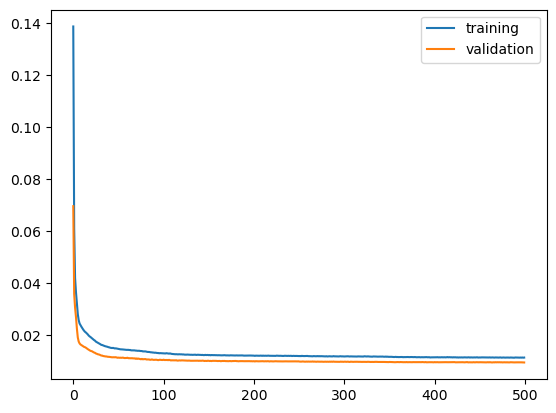

Training loss with no regularization and no dropout:  0.009767609
Valid loss:  0.009412522


In [29]:
import matplotlib.pyplot as plt 
print('Last training loss: ',trainer.train_loss[-1])
print('Last valid loss: ',trainer.valid_loss[-1])
xaxix = np.arange(len(trainer.train_loss))
plt.plot(xaxix,trainer.train_loss,label  = 'training')
plt.plot(xaxix,trainer.valid_loss,label  = 'validation')
plt.legend()
plt.show() 


def r2_quantile_loss
trainer.model.eval()
with torch.no_grad():
    data_train = [[x_b,y_b,t_b] for x_b,y_b,t_b in trainer.dataloader['train']]
    X_train,Y_train,T_train = torch.cat([x_b for x_b,y_b,t_b in data_train]),torch.cat([y_b for x_b,y_b,t_b in data_train]),torch.cat([t_b for x_b,y_b,t_b in data_train])
 
    if trainer.args_embedding is not None: 
        pred = trainer.model(X_train,T_train.long())
    else:
        pred = trainer.model(X_train)
    loss_train = trainer.loss_function(pred,Y_train)
    print('Training loss with no regularization and no dropout: ',loss_train.detach().numpy())

trainer.model.eval()
with torch.no_grad():
    data_valid = [[x_b,y_b,t_b] for x_b,y_b,t_b in trainer.dataloader['validate']]
    X_valid,Y_valid,T_valid = torch.cat([x_b for x_b,y_b,t_b in data_valid]),torch.cat([y_b for x_b,y_b,t_b in data_valid]),torch.cat([t_b for x_b,y_b,t_b in data_valid])
 
    if trainer.args_embedding is not None: 
        pred_valid = trainer.model(X_valid,T_valid.long())
    else:
        pred_valid = trainer.model(X_valid)
    loss_valid = trainer.loss_function(pred_valid,Y_valid)

    r2_valid = loss_valid/Y_valid.mean()
    print('Valid loss: ',loss_valid.detach().numpy())





In [ ]:
config = get_config(model_name = 'CNN')

config['conformity_scores_type'] = 'max_residual' 
config['seq_length'] = L

args = get_parameters(config)
args.epochs = 100

# Load train and calib model 
print(f"Type of model: {args.model_name} \n Loss function type: {args.loss_function_type} \n Quantile Method : {args.quantile_method} \n Calendar Class: {args.calendar_class} \n")
(dataset,U,Utarget) = load_normalized_dataset(subway_in,time_step_per_hour,args.train_prop,step_ahead,H,D,W,invalid_dates)
time_slots_labels,dic_class2rpz,dic_rpz2class = get_time_slots_labels(dataset,type_class= args.calendar_class)
data_loader_obj = DictDataLoader(U,Utarget,args.train_prop,args.valid_prop,validation = 'classic', shuffle = True, calib_prop=args.calib_prop, time_slots = time_slots_labels)
data_loader = data_loader_obj.get_dictdataloader(args.batch_size)

# Quantile Loss
quantiles = torch.Tensor([args.alpha/2,1-args.alpha/2]).to(args.device)
assert args.out_dim == len(quantiles), "Output dimension doesn't match with the number of estimated quantiles"
loss_function = get_loss(args.loss_function_type,quantiles)

# Load model : 
model = load_model(args,args_embedding)
model.to(args.device)
optimizer = choose_optimizer(model,args)

trainer = Trainer(model,data_loader,args,optimizer,loss_function,scheduler = None,args_embedding = args_embedding)  # Ajoute dans trainer, if calibration_prop is not None .... et on modifie le dataloader en ajoutant un clabration set
trainer.train_and_valid(mod = 1000)  # Récupère les conformity scores sur I1, avec les estimations faites precedemment 
Q = trainer.conformal_calibration(args.alpha,dataset,conformity_scores_type =args.conformity_scores_type, quantile_method = args.quantile_method)  # calibration for PI 90%
    
(preds,Y_true,T_labels,df_metrics) = trainer.testing(dataset,metrics= ['mse','mae'])
# ...


pi = trainer.CQR_PI(preds,Y_true,args.alpha,Q,T_labels.long())
results = get_dic_results(trainer,pi)

conformity_scores = trainer.conformity_scores
plot_bands_CQR(trainer,Y_true,preds,pi,window_pred,args.alpha,conformity_scores,results,bins = 100)

## Load Model 

In [ ]:
nb_trial = 1

for _ in range(nb_trial):
    config = get_config(model_name = 'CNN')

    config['conformity_scores_type'] = 'max_residual' 
    config['seq_length'] = L

    args = get_parameters(config)
    args.epochs = 100

    dataset,trainer,Q,preds,Y_true,T_labels = load_train_calib_model(args,args_embedding)
    pi = trainer.CQR_PI(preds,Y_true,args.alpha,Q,T_labels.long())
    results = get_dic_results(trainer,pi)

    conformity_scores = trainer.conformity_scores
    plot_bands_CQR(trainer,Y_true,preds,pi,window_pred,args.alpha,conformity_scores,results,bins = 100)

## Visu pour clustering 

In [ ]:
T_labels  # T_labels issus du Training 
trainer.model.eval()   # pas grad, pas de dropout 
with torch.no_grad():
    output = trainer.model.Tembedding(T_labels.long())

X1,Y1,Z1 = output[:,0].numpy(),output[:,1].numpy(),output[:,2].numpy()

x = np.arange(len(X1))
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(X1,Y1,Z1,label = 'embedding')
ax.legend()
plt.show()

In [ ]:
for training_mode in ['cal','train','validate','test']:
    print(training_mode)
    Pred_cal,Y_true_cal =trainer.test_prediction(allow_dropout = False,training_mode = 'cal')
    unorm_Pred_cal,unorm_Y_true_cal = dataset.unormalize_tensor(Pred_cal),dataset.unormalize_tensor(Y_true_cal)

    # PI 'classic' :
    pi_cal = PI_object(unorm_Pred_cal,unorm_Y_true_cal,alpha = args.alpha, type_calib = 'classic')
    print(pi_cal.mpiw,pi_cal.picp)

    # PI 'CQR' : 
    pi_cqr_cal = PI_object(unorm_Pred_cal,unorm_Y_true_cal,alpha = args.alpha, Q = Q, type_calib = 'CQR')
    print(pi_cqr_cal.mpiw,pi_cqr_cal.picp)

    plt.plot(np.arange(100),pi_cqr_cal.upper[:100,0,0],color = 'green',linestyle = 'dashed',label = f"PI, with Q = {'{:.2f}'.format(pi_cqr_cal.Q[0,0,0].item())}")
    plt.plot(np.arange(100),pi_cqr_cal.lower[:100,0,0],color = 'green',linestyle = 'dashed')
    plt.plot(np.arange(100),pi_cal.upper[:100,0,0],color = 'red',linestyle = 'dashed',label = 'quantile')
    plt.plot(np.arange(100),pi_cal.lower[:100,0,0],color = 'red',linestyle = 'dashed')
    plt.plot(np.arange(100),unorm_Y_true_cal[:100,0,0],color = 'blue')
    plt.legend()

In [ ]:
# PI des quantiles est trop large (97%). Donc, Q devrait être négatif 
model = trainer.model
model.eval()
with torch.no_grad():
    data = [[x_b,y_b] for  x_b,y_b in trainer.dataloader['cal']]
    X_cal,Y_cal = torch.cat([x_b for [x_b,y_b] in data]),torch.cat([y_b for [x_b,y_b] in data])
    preds = model(X_cal) # x_cal is normalized

    # get lower and upper band
    if preds.size(-1) == 2:
        lower_q,upper_q = preds[...,0].unsqueeze(-1),preds[...,1].unsqueeze(-1)   # The Model return ^q_l and ^q_u associated to x_b

    elif preds.size(-1) == 1:
        lower_q,upper_q = preds,preds 
    else:
        raise ValueError(f"Shape of model's prediction: {preds.size()}. Last dimension should be 1 or 2.")
    
    # unormalized lower band, upper band, and Y_cal 
    lower_q, upper_q = dataset.unormalize_tensor(lower_q),dataset.unormalize_tensor(upper_q)
    Y_cal = dataset.unormalize_tensor(Y_cal)

    # Confority scores and quantiles
    if args.conformity_scores_type == 'max_residual':
        conformity_scores = torch.max(lower_q-Y_cal,Y_cal-upper_q) # Element-wise maximum        #'max(lower_q-y_b,y_b-upper_q)' is the quantile regression error function
    if args.conformity_scores_type == 'max_residual_plus_middle':
        print("|!| Conformity scores computation is not based on 'max(ql-y, y-qu)'")
        conformity_scores = torch.max(lower_q-Y_cal,Y_cal-upper_q) + ((lower_q>Y_cal)(upper_q<Y_cal))*(upper_q - lower_q)/2  # Element-wise maximum        #'max(lower_q-y_b,y_b-upper_q)' is the quantile regression error function 

    quantile_order = torch.Tensor([np.ceil((1 - args.alpha)*(X_cal.size(0)+1))/X_cal.size(0)])
    Q = torch.quantile(conformity_scores, quantile_order, dim = 0) #interpolation = 'higher'

In [ ]:
lower_q[:10,0,0],upper_q[:10,0,0],Y_cal[:10,0,0]

In [ ]:
Pred_test,Y_true_test =trainer.test_prediction(allow_dropout = False,training_mode = 'test')
pi_test = PI_object(Pred_test,Y_true_test,alpha = args.alpha, type_calib = 'classic')
print(pi_test.mpiw,pi_test.picp)

plt.plot(np.arange(100),Pred_test[:100,0,0],color = 'red',linestyle = 'dashed')
plt.plot(np.arange(100),Pred_test[:100,0,1],color = 'red',linestyle = 'dashed')
plt.plot(np.arange(100),Y_true_test[:100,0,0],color = 'blue')

In [ ]:
Pred_valid,Y_true_valid =trainer.test_prediction(allow_dropout = False,training_mode = 'validate')
pi_valid = PI_object(Pred_valid,Y_true_valid,alpha = args.alpha, type_calib = 'classic')
print(pi_valid.mpiw,pi_valid.picp)

plt.plot(np.arange(100),Pred_valid[:100,0,0],color = 'red',linestyle = 'dashed')
plt.plot(np.arange(100),Pred_valid[:100,0,1],color = 'red',linestyle = 'dashed')
plt.plot(np.arange(100),Y_true_valid[:100,0,0],color = 'blue')

In [ ]:
Pred_train,Y_true_train =trainer.test_prediction(allow_dropout = False,training_mode = 'train')
pi_train = PI_object(Pred_train,Y_true_train,alpha = args.alpha, type_calib = 'classic')
print(pi_train.mpiw,pi_train.picp)

plt.plot(np.arange(100),Pred_train[:100,0,0],color = 'red',linestyle = 'dashed')
plt.plot(np.arange(100),Pred_train[:100,0,1],color = 'red',linestyle = 'dashed')
plt.plot(np.arange(100),Y_true_train[:100,0,0],color = 'blue')

A priori, ça ne sert à rien de les projeté dans un espace de plus grande dimension.
- J'ai un ensemble de 'mot'. Chaque mot correspond a une combinaison (d,h,m).
- Il y a 7 jours, 24h, 4 time-step de minute (0,15,30,45). Donc j'ai un ensemble de 4*7*24 = 672 mots.
- J'aimerais faire un embedding de ces mots. C'est a dire représenter chaque mot par un vecteur. 

Exemple : 
(0,7,0) est 'Lundi 8h15'. J'en fais un embedding (donc une projection) dans un espace latent (exemple en dimension 3):


**Problème** : très peu d'occurence de chacun des 'mots' (En tout une semaine pour balayer une seule fois chaucn des mots possible. Donc 1 an de Training c'est seulement 57 apparitions...)